# Hankel Alternative View of Koopman (HAVOK)

In this tutorial, we demonstrate several basic use cases of the Hankel Alternative View of Koopman (HAVOK) approach [1] for modeling chaotic systems with partial measurements. In particular, we apply HAVOK to the chaotic Lorenz system and examine each of the following scenarios:

- Basic HAVOK application with ideal data
- Pairing HAVOK with alternate DMD methods for noisy data

We begin with some basic imports, including `numpy` for computations, `matplotlib` for plotting, `solve_ivp` for data simulation, and the `HAVOK` module of the PyDMD package for HAVOK applications.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

from pydmd import HAVOK

## The Chaotic Lorenz System

Throughout this tutorial, we examine the Lorenz system

$$
\begin{cases}
\dot{x} = \sigma (y-x) \\
\dot{y} = x(\rho-z)-y \\ 
\dot{z} = xy - \beta z
\end{cases}
$$

for the parameters $\sigma, \rho, \beta = 10, 28, 8/3$ and the initial condition $(x_0, y_0, z_0) = (-8,8,27)$. Below we provide code that uses `scipy.integrate.solve_ivp` to propagate this system forward in time. We additionally provide code that uses $x$ data from the Lorenz system in order to detect lobe switching events.

In [2]:
def generate_lorenz_data(t_eval):
    """
    Given a time vector t_eval = t1, t2, ..., evaluates and returns
    the snapshots of the Lorenz system as columns of the matrix X.
    """
    def lorenz_system(t, state):
        sigma, rho, beta = 10, 28, 8/3 # chaotic parameters
        x, y, z = state
        x_dot = sigma * (y - x)
        y_dot = (x * (rho - z)) - y
        z_dot = (x * y) - (beta * z)
        return [x_dot, y_dot, z_dot]

    # Set integrator keywords to replicate the odeint defaults
    integrator_keywords = {}
    integrator_keywords["rtol"] = 1e-12
    integrator_keywords["atol"] = 1e-12
    integrator_keywords["method"] = "LSODA"

    sol = solve_ivp(
        lorenz_system,
        [t_eval[0], t_eval[-1]],
        [-8, 8, 27],
        t_eval=t_eval,
        **integrator_keywords,
    )

    return sol.y

def get_ind_switch_lorenz(x):
    """
    Get indices of true lobe switching of the Lorenz system given x data.
    """
    ind_switch = np.sign(x[:-1]) - np.sign(x[1:]) != 0
    ind_switch = np.append(ind_switch, False)
    ind_switch = np.where(ind_switch)[0]

    return ind_switch

We start by simulating Lorenz data for the fine time step $\Delta t = 0.001$ over $m = 50000$ time points. We then plot the full-state Lorenz system, along with the $x$ coordinate from the Lorenz system. Throughout this tutorial, we assume that we only have access to $x$ coordinate data. This will be our partial measurement data.

Note that this data set is quite ideal because it is clean, finely-sampled, and abundant with data points. We will adjust these attributes as we advance throughout the tutorial.

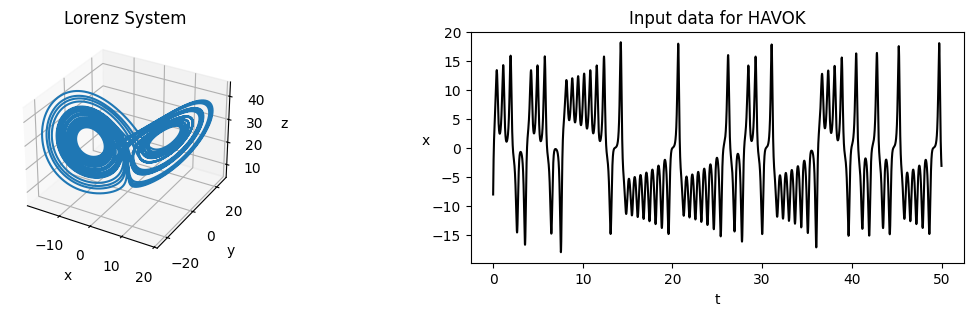

In [3]:
# Generate Lorenz system data.
dt = 0.001 # time step
m = 50000  # number of data samples
t = np.arange(m) * dt
X = generate_lorenz_data(t)
x = X[0]

# Plot the 3D attractor.
fig = plt.figure(figsize=(14, 3))
ax = fig.add_subplot(121, projection="3d")
ax.plot(X[0], X[1], X[2])
ax.set_title("Lorenz System")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
# Plot the x time-series.
ax = fig.add_subplot(122)
ax.set_title("Input data for HAVOK")
ax.plot(t, x, c="k")
ax.set_xlabel("t")
ax.set_ylabel("x", rotation=0)
plt.show()

## Basic HAVOK application

In order to apply HAVOK to your data, simply initialize a `HAVOK` model with your desired parameters and invoke the model's `fit` method. Note that input snapshots and time information (either all times of data collection or the time-step $\Delta t$) are both necessary for model fitting.

Once fitted, the `HAVOK`-specific `plot_summary` function may be used to visualize all major HAVOK results. These results include:
- The time-series used to fit the HAVOK model.
- The HAVOK regression matrix, which contains the operators $\mathbf{A}$ and $\mathbf{B}$, as well as the "bad fit".
- The first time-delay coordinate $v_1$.
- The forcing input term $v_r$ and the times the forcing is considered "active".
- The attractor recovered via time-delay, plotted with the "active" times.
- The attractor that is reconstructed using the fitted HAVOK model.

Notice that by applying HAVOK, we are able to (1) recover an attractor that very closely ressembles the true full-state system, (2) obtain a forcing signal that "activates" prior to switching events, and (3) obtain a linear regression model that very accurately models our time-delay coordinates, all from just $x$ coordinate data alone!

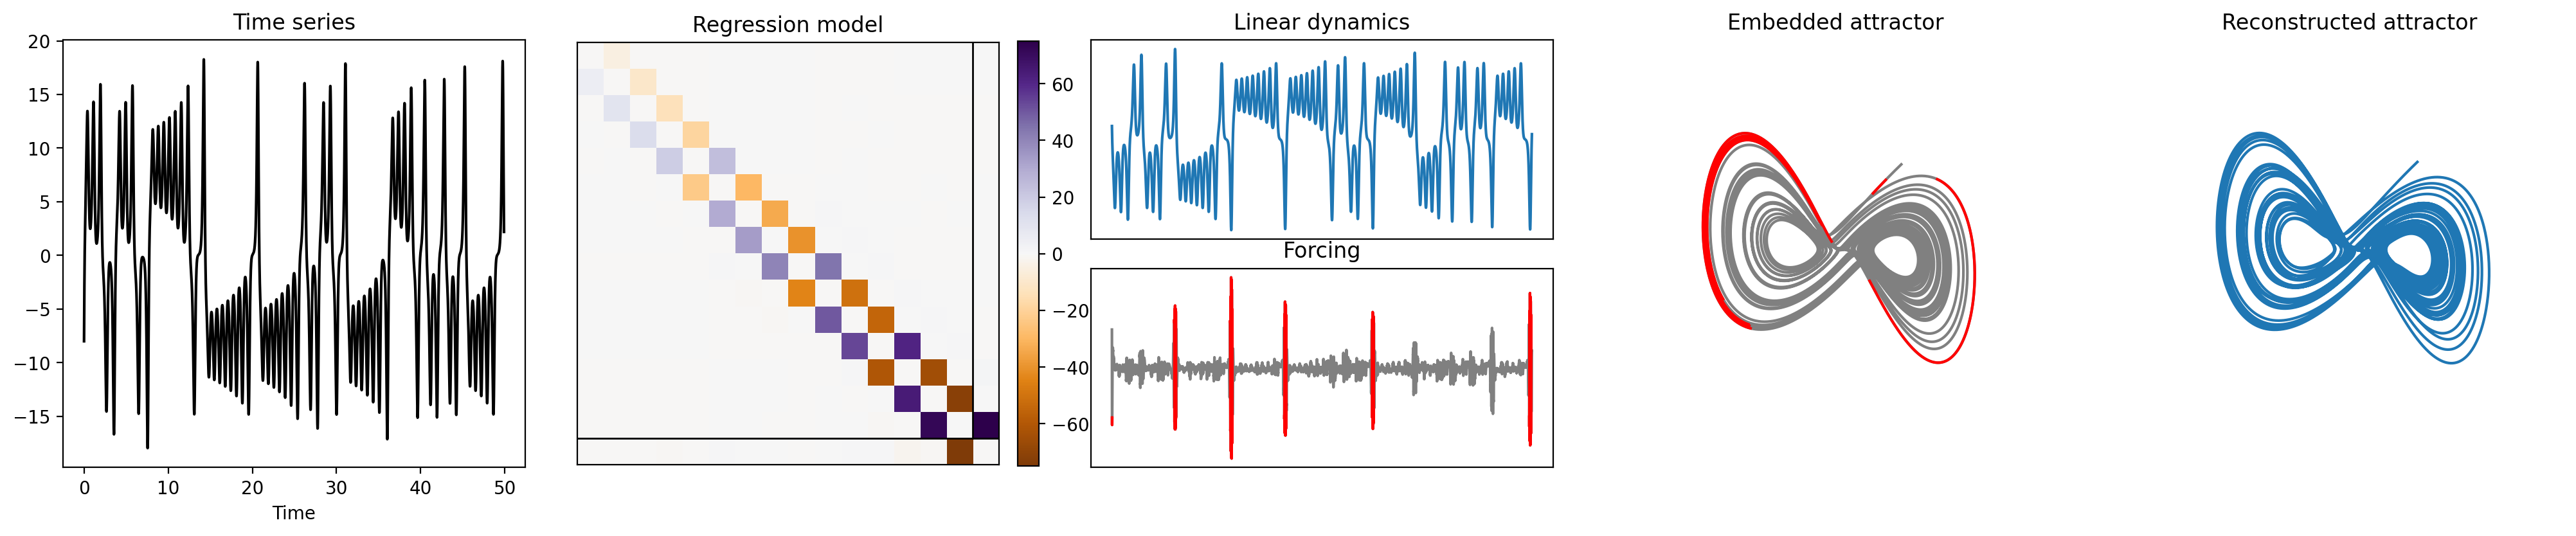

In [4]:
havok = HAVOK(svd_rank=16, delays=100)
havok.fit(x, t)
havok.plot_summary()

The `plot_summary` function is also quite customizable. Here are just a handful of ways in which one might customize their plots. See method documentation for more details.

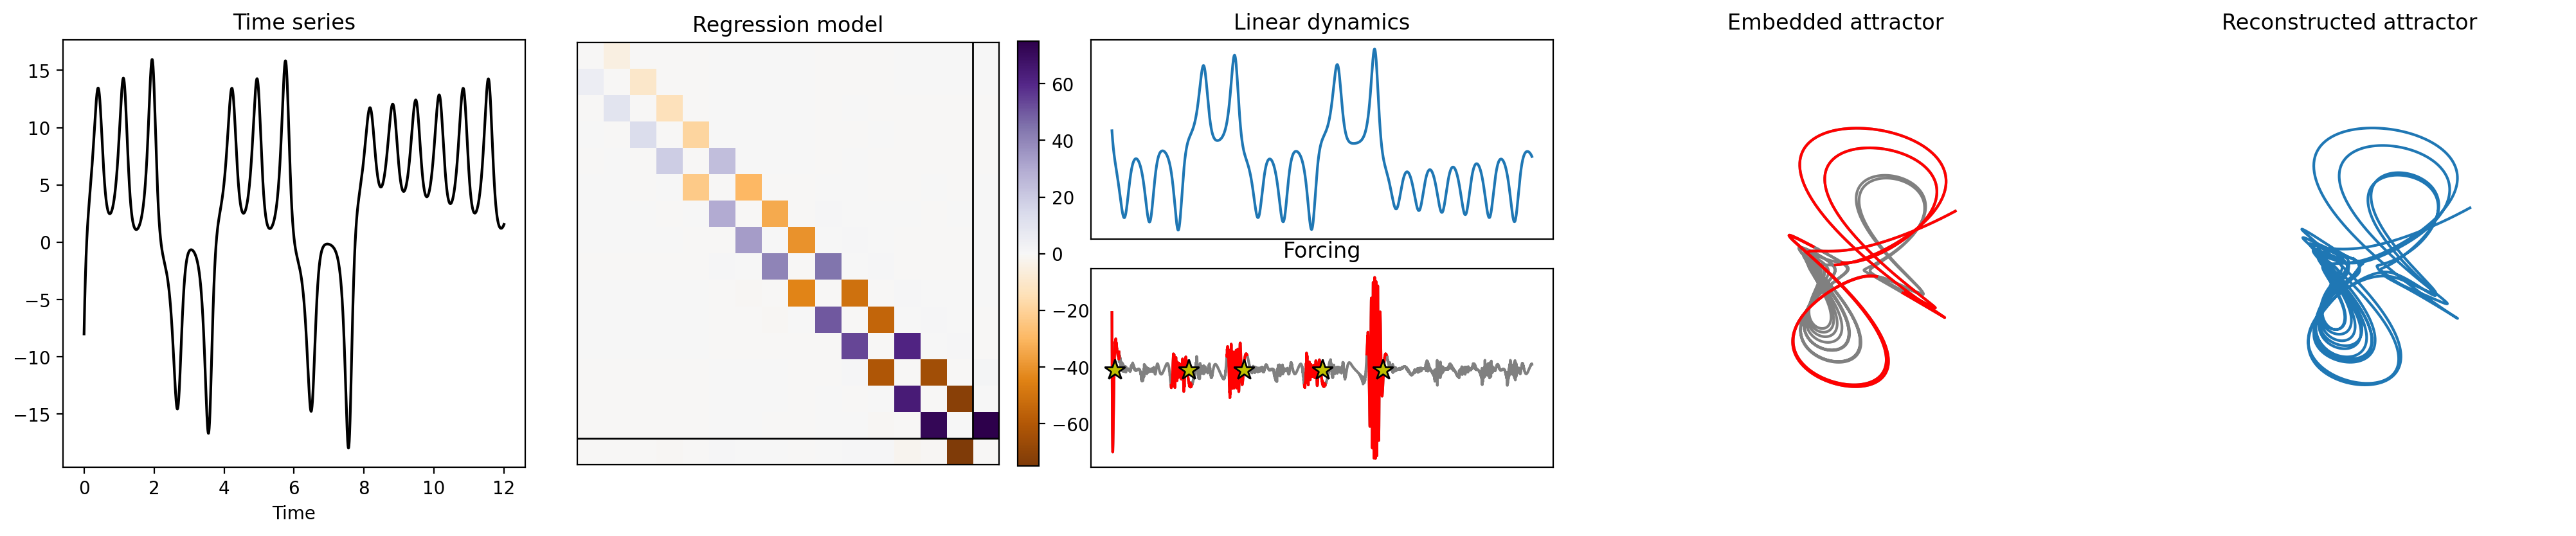

In [5]:
havok.plot_summary(
    # number of data points to plot
    num_plot=12000,
    # indices of the embeddings to plot and their order
    index_linear=(2,0,1),
    # threshold at which the forcing is considered large enough to be active
    forcing_threshold=0.005,
    # indices of true switching events (plotted on the forcing plot as as stars)
    true_switch_indices=get_ind_switch_lorenz(x),
)

Once fitted, `HAVOK` models can reconstruct the data using just the computed regression matrix and the initial condition on the linear dynamics.

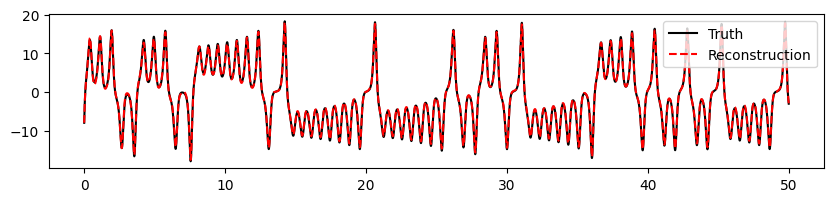

In [6]:
plt.figure(figsize=(10, 2))
plt.plot(t, x, c="k", label="Truth")
plt.plot(t, havok.reconstructed_data, "--", c="r", label="Reconstruction")
plt.legend()
plt.show()

And generally speaking, fitted `HAVOK` models can also make predictions as long as they are provided with an input forcing signal that goes beyond the training set.

Here, we demonstrate how the `HAVOK` model fitted previously is able to obtain a pretty decent prediction of the data for later times as long as it is given a forcing signal for those later times.

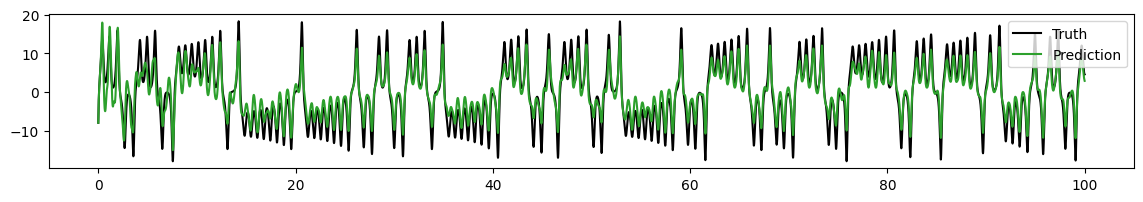

In [7]:
# Build a longer data set and fit a HAVOK model to it.
t_long = np.arange(2 * m) * dt
x_long = generate_lorenz_data(t_long)[0]
havok_long = HAVOK(svd_rank=16, delays=100).fit(x_long, t_long)

# We only use the long HAVOK model to obtain a long forcing signal.
forcing_long = havok_long.forcing
time_long = t_long[:len(forcing_long)]

# Make a prediction using the long forcing signal.
# Use the HAVOK model fitted to the shorter data set.
plt.figure(figsize=(14, 2))
plt.plot(t_long, x_long, c="k", label="Truth")
plt.plot(t_long, havok.predict(forcing_long, time_long), label="Prediction", c="tab:green")
plt.legend()
plt.show()

`HAVOK` models also store SVD information. Invoke the `modes` attribute in order to view the entries of the $\mathbf{U}$ matrix. Similarly, invoke the `singular_vals` attribute for the entries of $\mathbf{\Sigma}$.

Below, we highlight the 16 leading singular values in order to clarify our consistent usage of `svd_rank=16`.

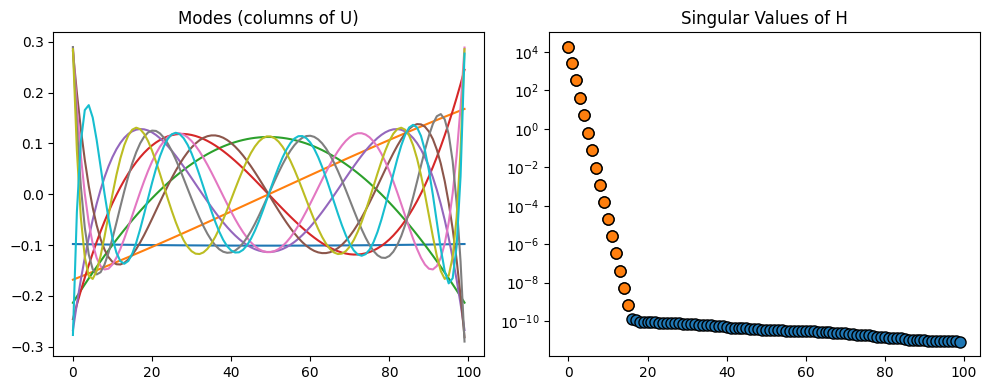

In [8]:
# Visualize the columns of U.
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Modes (columns of U)")
havok = HAVOK(svd_rank=10, delays=100).fit(x, t)
plt.plot(havok.modes)

# Visualize the entries of Sigma. (Highlight the first 16.)
plt.subplot(1, 2, 2)
plt.title("Singular Values of H")
havok = HAVOK(svd_rank=-1, delays=100).fit(x, t)
plt.plot(havok.singular_vals, "o", mec="k", ms=8)
plt.plot(havok.singular_vals[:16], "o", mec="k", ms=8)
plt.semilogy()
plt.tight_layout()
plt.show()

Another nifty feature of the `HAVOK` module is that it comes equipped with threshold computation tools. Simply invoke the `compute_threshold` function 

In [9]:
np.sort([-3, 2, 1])

array([-3,  1,  2])

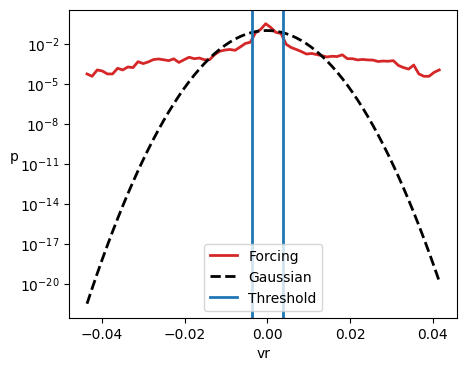

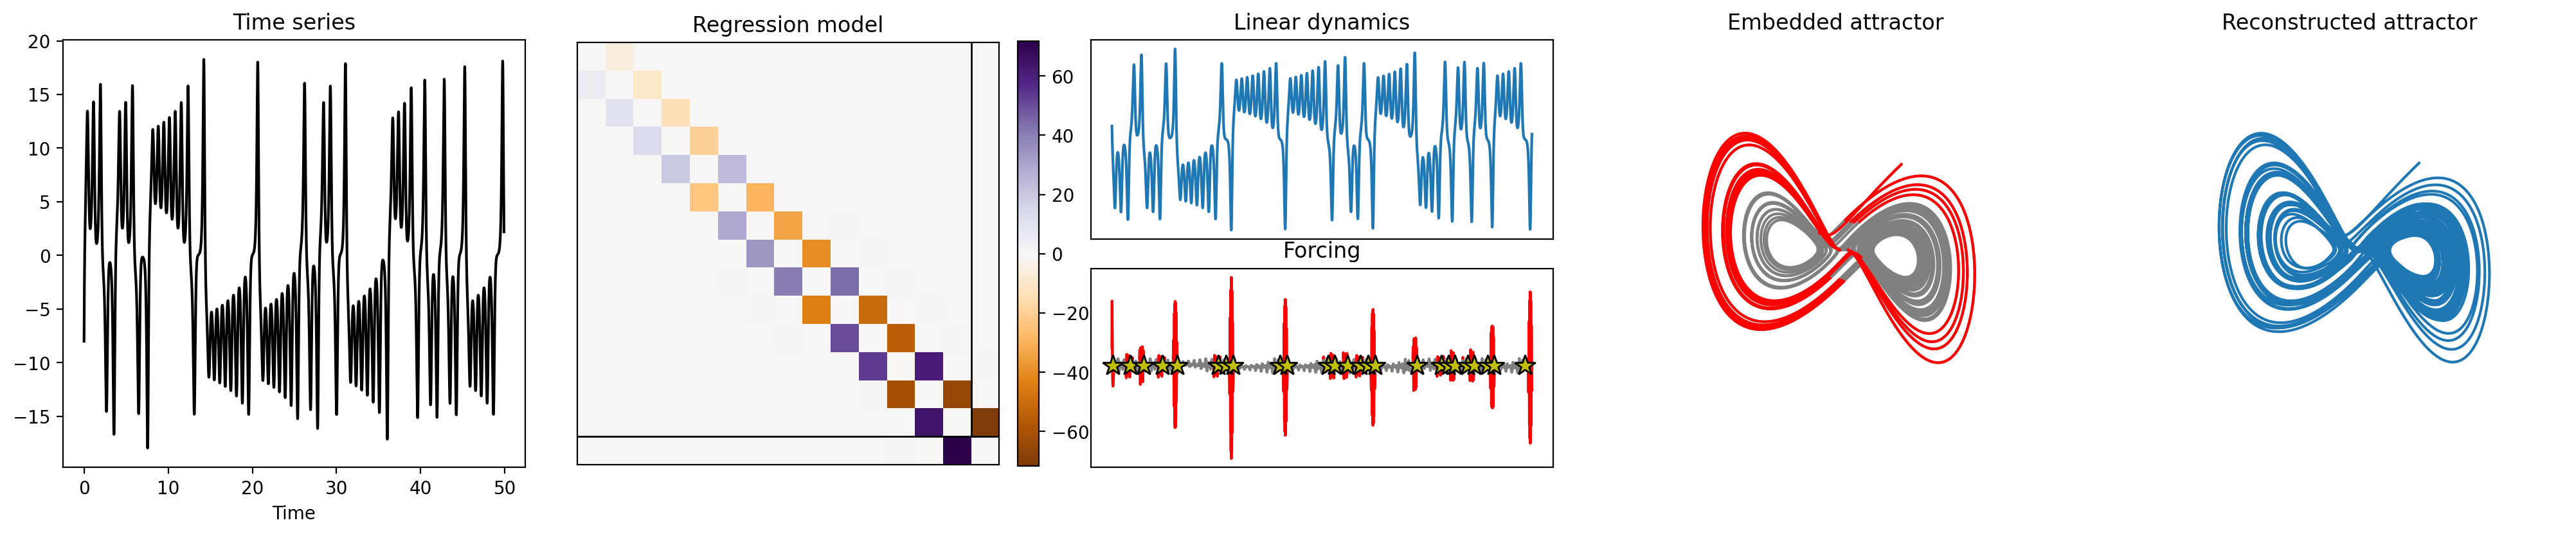

In [9]:
vr = havok.forcing[:, 0]

thres = havok.compute_threshold(vr, p=0.1, plot=True, bins=70)
havok.plot_summary(forcing_threshold=thres, true_switch_indices=get_ind_switch_lorenz(x))

Above, we adjust the `svd_rank` and the `delays` parameters, which are arguably the two most significant parameters of the HAVOK algorithm. `svd_rank` controls the rank of the fit, or essentially 

, while `delays` controls the number of time-delays


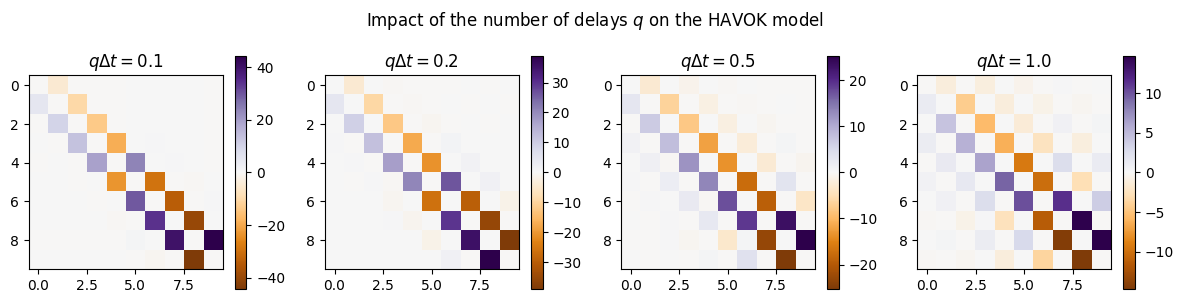

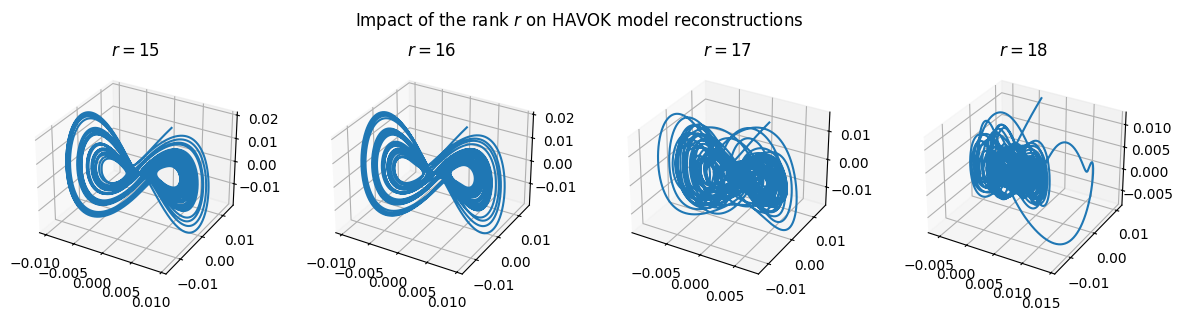

In [10]:
delay_values = [100, 200, 500, 1000]
rank_values = [15, 16, 17, 18]

plt.figure(figsize=(12, 3))
plt.suptitle("Impact of the number of delays $q$ on the HAVOK model")
for i, delays in enumerate(delay_values):
    havok = HAVOK(svd_rank=10, delays=delays)
    havok.fit(x, t)
    vmax = np.abs(havok.operator).max()
    plt.subplot(1, len(delay_values), i + 1)
    plt.title(f"$q \Delta t = {delays * dt}$")
    plt.imshow(havok.operator, vmax=vmax, vmin=-vmax, cmap="PuOr")
    plt.colorbar()
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12, 3))
plt.suptitle("Impact of the rank $r$ on HAVOK model reconstructions")
for i, svd_rank in enumerate(rank_values):
    havok = HAVOK(svd_rank=svd_rank, delays=100)
    havok.fit(x, t)
    ax = fig.add_subplot(1, len(rank_values), i + 1, projection="3d")
    ax.set_title(f"$r = {svd_rank}$")
    ax.plot(
        havok.reconstructed_embeddings[:, 0],
        havok.reconstructed_embeddings[:, 1],
        havok.reconstructed_embeddings[:, 2],
    )
plt.tight_layout()
plt.show()

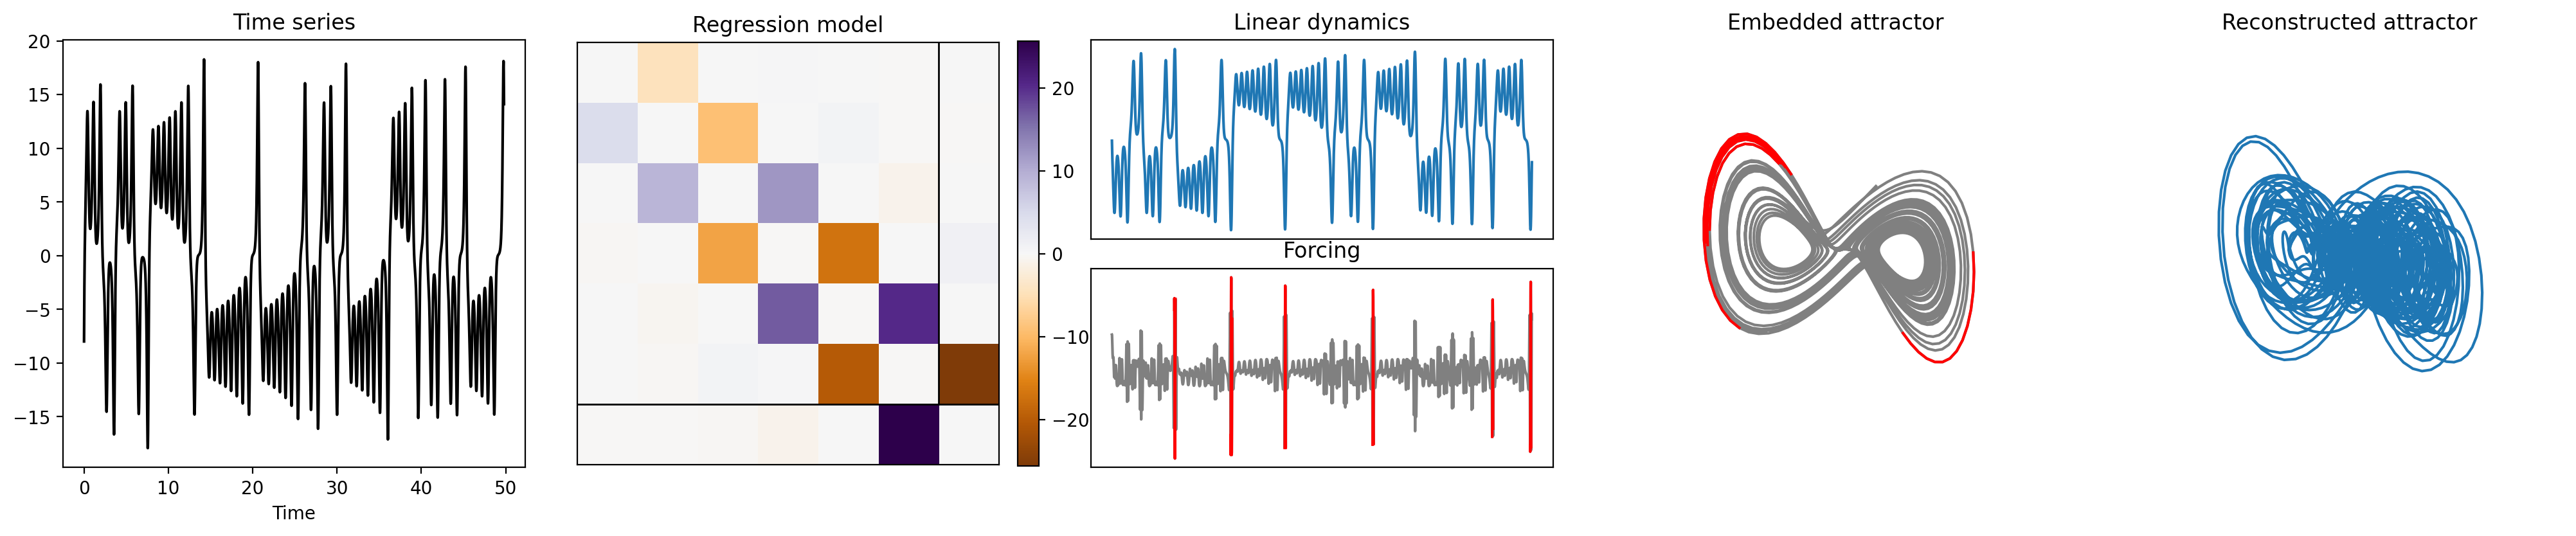

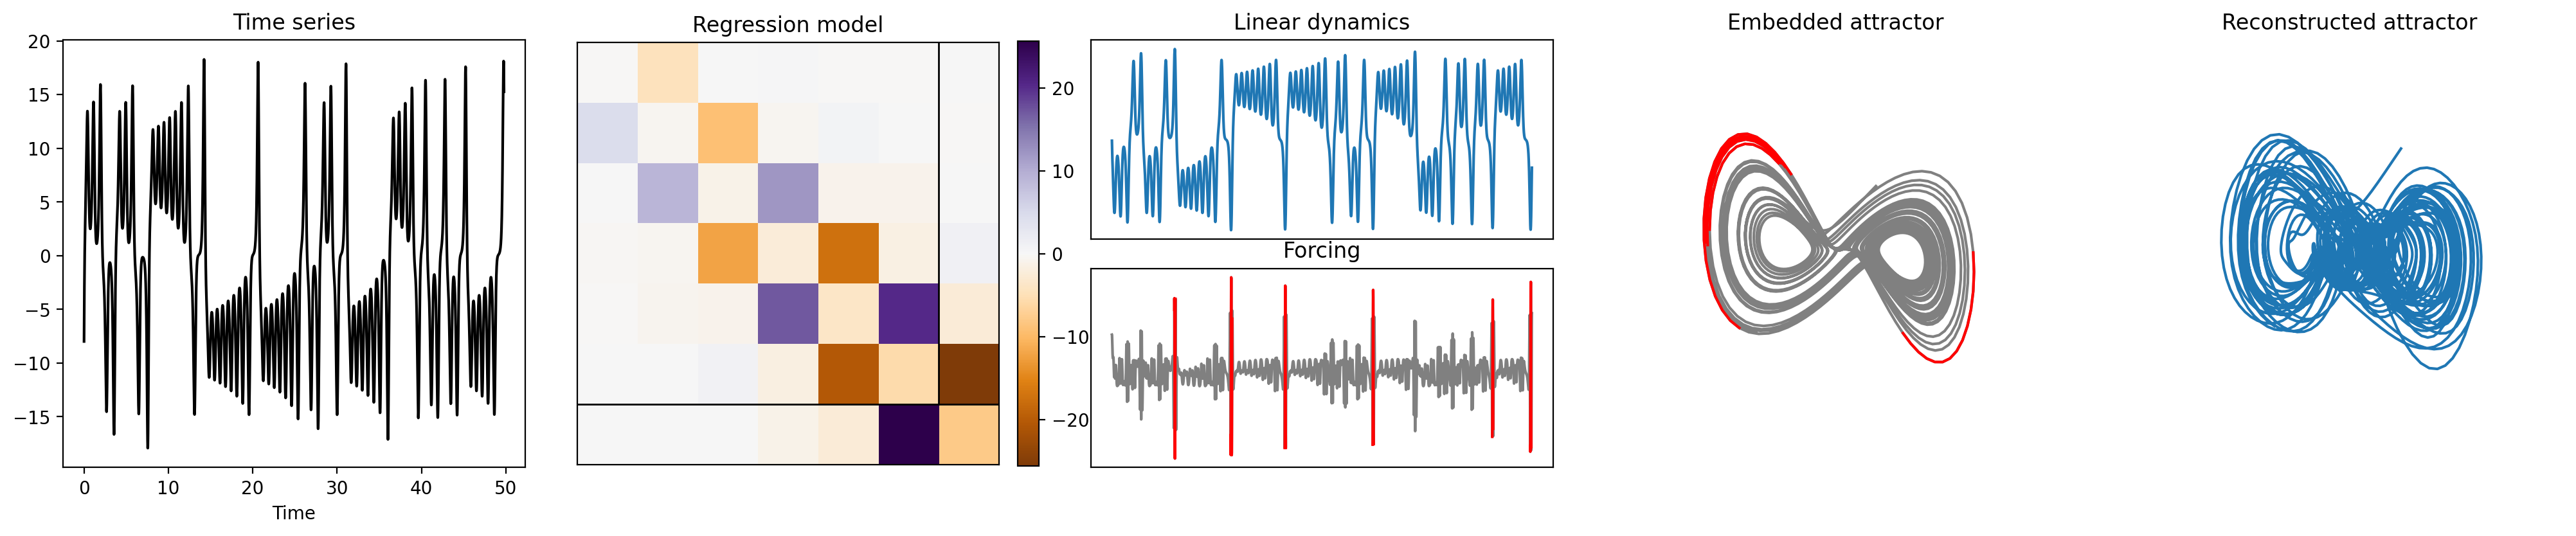

In [25]:
havok = HAVOK(svd_rank=7, delays=20).fit(x[::10], t[::10])
havok.plot_summary()

havok = HAVOK(svd_rank=7, delays=20, structured=True).fit(x[::10], t[::10])
havok.plot_summary()

## References:

[1] S. L. Brunton, B. W. Brunton, J. L. Proctor, E. Kaiser, and J. N. Kutz, *Chaos
as an intermittently forced linear system*, Nature Communications, 8 (2017), pp. 1–9. [https://doi.org/10.1038/s41467-017-00030-8](https://doi.org/10.1038/s41467-017-00030-8)

[2] S. M. Hirsh, S. M. Ichinaga, S. L. Brunton, J. N. Kutz, and B. W. Brunton,
*Structured time-delay models for dynamical systems with connections to frenet–serret frame*,
Proceedings of the Royal Society A, 477 (2021). art. 20210097. [http://doi.org/10.1098/rspa.2021.0097](http://doi.org/10.1098/rspa.2021.0097)